In [1]:
push!(LOAD_PATH, "../src")
using Pkg
Pkg.instantiate()
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U

In [3]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall C:\Users\bahaa\.julia\packages\PyCall\1gn3u\src\PyCall.jl:719
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda C:\Users\bahaa\.julia\packages\Conda\zReqD\src\Conda.jl:181


Channels:
 - conda-forge
Platform: win-64
Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda





## Package Plan ##

  environment location: C:\Users\bahaa\.julia\conda\3\x86_64

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |            2_gnu          48 KB  conda-forge
    brotli-1.1.0               |       h2466b09_3          20 KB  conda-forge
    brotli-bin-1.1.0           |       h2466b09_3          21 KB  conda-forge
    cairo-1.18.4               |       h5782bbf_0         1.5 MB  conda-forge
    contourpy-1.3.3            |  py312hf90b1b7_2         220 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_1          13 KB  conda-forge
    double-conversion-3.3.1    |       he0c23c2_0          70 KB  conda-forge
    font-ttf-dejavu-sans-mono-2.37|       hab24e00_0         388 KB  conda-forge
    font-ttf-inconsolata-3.000 |       h77eed37_0          94 KB  conda-forge
    font-ttf-source-code

"module://matplotlib_inline.backend_inline"

In [4]:
# Load in system parameters - Participation factors and mode frequencies
sysparams = open("../system params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [5]:
# Constants across notebook
const nions = 13

# Objective function for optimization
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

Function for Generating one gate pair and printing results:

In [16]:
function gen_gate(
    ion1,  # Ion 1 and 2 in gate pair, counted in chain from left to right starting at 1
    ion2, 
    min_τ, # min and max gate time (τ)
    max_τ, 
    min_Ω, # min and max rabi frequency (Ω)
    max_Ω, 
    min_ω, # min and max drive frequencies (ω)
    max_ω, 
    blackman_ratio=0.7, # ratio of the amplitude profile where the amplitude is at max
    nseg = 120, # number of segments for the gate
    niter = 150, # number of iterations of optimization
    )
    # Construct modes matrix using system parameters
    modes = Seq.Modes()
    for i in 1:13
        push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
    end

    # Define amplitude profile as blackman pulse
    blackman_start_end = U.BlackmanStartEnd{blackman_ratio}()

    # Make plotting and optimization buffers
    buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
    buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

    # Nonlinear optimization model using objective function
    nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end));
    nargs = Seq.nparams(nlmodel)
    tracker = Opts.NLVarTracker(nargs)

    # Set bounds for optimizer
    Opts.set_bound!(tracker, nlmodel.param.τ, min_τ, max_τ)
    Opts.set_bound!(tracker, nlmodel.param.Ωs[1], min_Ω, max_Ω)
    for ω in nlmodel.param.ωs
        Opts.set_bound!(tracker, ω, min_ω, max_ω)
    end

    opt = NLopt.Opt(:LD_LBFGS, nargs)
    NLopt.min_objective!(opt, nlmodel)
    NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
    NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
    NLopt.maxtime!(opt, 10)

    # optimize for gate (keep track of best)
    best_obj = Inf
    best_params = nothing
    last_ret = nothing
    for i in 1:niter
        obj, params, ret = NLopt.optimize(opt, Opts.init_vars!(tracker))
        last_ret = ret
        # skip failed runs (negative ret code)
        if getfield(NLopt, ret) < 0
            continue
        end
        if obj < best_obj && params !== nothing
            best_obj = obj
            best_params = params
        end
    end

    # Try one last time with previous best initial guess if we have none
    if best_params === nothing
        # attempt a deterministic initialization: use middle of bounds where possible
        init = Opts.init_vars!(tracker)
        obj, params, ret = NLopt.optimize(opt, init)
        if getfield(NLopt, ret) < 0 || params === nothing
            error("gen_gate: optimizer failed to find feasible parameters after $(niter) iterations. Increase niter, increase NLopt.maxtime!, or loosen bounds.")
        end
        best_params = params
        best_obj = obj
    end

    # Build plotting kernel for callers to compute totals/areas
    kern = SL.Kernel(buf_plot, Val(SL.pmask_full));
    return Seq.RawParams(nlmodel, best_params), kern, modes
end

gen_gate (generic function with 4 methods)

### All optimization parameters can be updated here:

In [13]:
# Utility functions
pitime_to_Ω(time) = π / (2 * time)
idx_to_chain_position(ion_idx) = ion_idx - (nions + 1) ÷ 2 # For example, ion 7 -> pos 0 or ion 5 -> pos -2
chain_position_to_idx(ion_pos) = ion_pos + (nions + 1) ÷ 2 # For example, pos 0 -> ion 7 or pos -2 -> ion 5

chain_position_to_idx (generic function with 1 method)

In [ ]:
# Define a set of parameter sets.
# Each dict represents one gate to be generated
param_sets = [
    Dict(
        :ion1 => chain_position_to_idx(-2), :ion2 => chain_position_to_idx(2),
        :min_τ => 0.1, :max_τ => 2.5,
        :min_Ω => pitime_to_Ω(8), :max_Ω => pitime_to_Ω(3.8),
        :min_ω => 2π * sysparams.modes.radial1[2], :max_ω => 2π * sysparams.modes.radial1[11],
        :blackman_ratio => 0.7, :nseg => 120, :niter => 150
    ),
    Dict(
        :ion1 => chain_position_to_idx(-1), :ion2 => chain_position_to_idx(1),
        :min_τ => 0.1, :max_τ => 2.5,
        :min_Ω => pitime_to_Ω(8), :max_Ω => pitime_to_Ω(3.8),
        :min_ω => 2π * sysparams.modes.radial1[2], :max_ω => 2π * sysparams.modes.radial1[11],
        :blackman_ratio => 0.7, :nseg => 120, :niter => 150
    )
    # Add more sets here if needed
]
# Containers for outputs
solution_dict = Dict()
results = Dict()
# Iterate over each parameter set and call the function
for params in param_sets
    ion1 = params[:ion1]
    ion2 = params[:ion2]
    min_τ = params[:min_τ]
    max_τ = params[:max_τ]
    min_Ω = params[:min_Ω]
    max_Ω = params[:max_Ω]
    min_ω = params[:min_ω]
    max_ω = params[:max_ω]
    blackman_ratio = params[:blackman_ratio]
    nseg = params[:nseg]
    niter = params[:niter]
    
    println("------------")
    println("Calling gen_gate with parameters:")
    println("ion1 = $ion1, ion2 = $ion2, min_τ = $min_τ, max_τ = $max_τ")
    println("min_Ω = $min_Ω, max_Ω = $max_Ω, min_ω = $min_ω, max_ω = $max_ω")
    println("blackman_ratio = $blackman_ratio, nseg = $nseg, niter = $niter")
    
    # Run optimization and collect outputs
    opt_raw_params, kern, modes = gen_gate(ion1, ion2, min_τ, max_τ, min_Ω, max_Ω, min_ω, max_ω, blackman_ratio, nseg, niter)
    
    pos1 = idx_to_chain_position(ion1)
    pos2 = idx_to_chain_position(ion2)
    key = "$(max(pos1, pos2)):$(min(pos1,pos2))"
    enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
    solution_dict[key] = GoldGates.XXSolution(opt_raw_params, enclosed_area)
    # store everything needed for later printing/plotting
    results[key] = (opt_raw_params, kern, modes, enclosed_area)
    println("Stored solution for $key")
    println("------------")
end

In [24]:
# Save the generated solutions
output_filename = "../out/20251020_linear_pm_13_v2.json"
solution_set = GoldGates.GateSolutionSet(params=sysparams, XX=solution_dict)
open(output_filename, "w") do io
    write(io, solution_set, format=:json)
end

In [25]:
# Print results for each stored solution
for (key, (opt_raw_params, kern, modes, enclosed_area)) in results
    println("---- Solution: $key ----")
    println("Total displacement:")
    println(Seq.total_dis(kern, opt_raw_params, modes))
    println("cumulative displacement:")
    println(Seq.total_cumdis(kern, opt_raw_params, modes))
    println("Gradient of displacement w.r.t. detuning (disδ)")
    println(Seq.total_disδ(kern, opt_raw_params, modes))
    println("Enclosed area (area)")
    println(enclosed_area)
    println("Gradient of enclosed area w.r.t. detuning (areaδ)")
    println(Seq.total_areaδ(kern, opt_raw_params, modes))
    println("-------------------------------")
end

---- Solution: 2:-2 ----
Total displacement:
1.8138753960618003e-9
cumulative displacement:
0.00016529204952010982
Gradient of displacement w.r.t. detuning (disδ)
2.4457417112328635e-8
Enclosed area (area)
1.5707797740666982
Gradient of enclosed area w.r.t. detuning (areaδ)
-23.501020234971172
-------------------------------
---- Solution: 1:-1 ----
Total displacement:
9.568087846918487e-7
cumulative displacement:
0.08377051344487751
Gradient of displacement w.r.t. detuning (disδ)
1.035498464557958e-5
Enclosed area (area)
-1.5708207060294406
Gradient of enclosed area w.r.t. detuning (areaδ)
46.084110856909504
-------------------------------


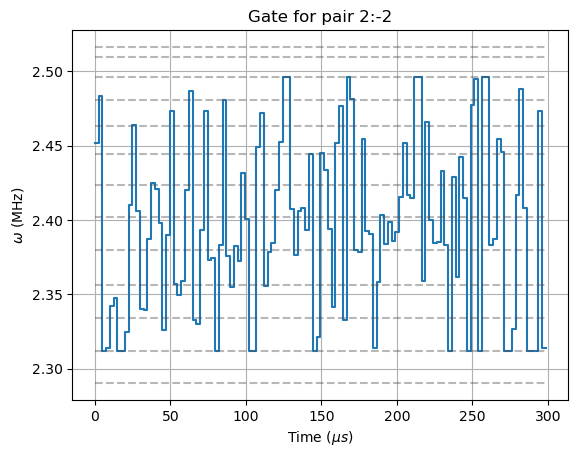

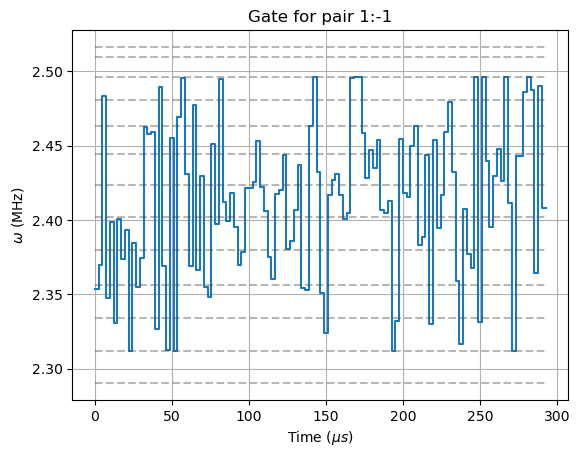

In [ ]:
# Plot each stored solution (drive frequency vs time with mode lines)
for (key, (opt_raw_params, kern, modes, enclosed_area)) in results
    figure()
    ts, ωs = Seq.get_ωs(opt_raw_params)
    plot(ts, ωs ./ 2π)
    title("Gate for pair $key")
    xmin = minimum(ts)
    xmax = maximum(ts)
    # Add horizontal lines for modes for plot
    for (i,f) in enumerate(sysparams.modes.radial1)
        plot([xmin, xmax], [f, f], linestyle="--", color="0.3", alpha=0.4)
    end
    xlabel(raw"Time ($\mu s$)")
    ylabel(raw"$\omega$ (Mrad/s)")
    grid()
    display(gcf())
end